# Github

In [3]:
# !pip install juanpy
import juanpy

In [5]:
help(juanpy)

Help on module juanpy:

NAME
    juanpy

FUNCTIONS
    trends(df, sensibilidad=None, escala='linear')
        Encuentra maximos y mínimos locales dada una sensibilidad (cantidad de velas de la ventana local)
    
    waves(df, sensibilidad=None, escala='linear')

FILE
    c:\users\floda\desktop\pythontraders\juanpy.py




In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime 

def trends(ticker, start='2000-01-01', end=None, sensibilidad=None, escala='linear'):
    '''
    Encuentra maximos y mínimos locales dada una sensibilidad (cantidad de velas de la ventana local)
    Gráfico 1: Precios de cierre con mínimos y máximos encontrados
    Grafico 2: Precios de cierre con lineas de soportes y resistencias desde cada máximo y mínimo encontrado
    Gráfico 3: Precios de cierre con zona alcista, bajista o lateral en función de las pendientes de los últimos pares de mínimos y máximos encontrados 
    '''

    if not end:
        end = datetime.datetime.now().strftime('%Y-%m-%d')
        
    data = yf.download(ticker, auto_adjust=True, start=start, end=end)
    k = sensibilidad if sensibilidad else len(data)//40
    
    r_max = data.Close.rolling(k).max()
    max_back = (data.Close == r_max)
    max_fw = max_back.shift(-k).rolling(k).sum() == 0
    data['loc_max'] = max_back & max_fw

    r_min = data.Close.rolling(k).min()
    min_back = (data.Close == r_min)
    min_fw = min_back.shift(-k).rolling(k).sum() == 0
    data['loc_min'] = min_back & min_fw

    pmin = data.loc[data['loc_min']==True].Close.pct_change()
    pmax = data.loc[data['loc_max']==True].Close.pct_change()
    vmin = r_min.loc[data['loc_min']==True]
    vmax = r_max.loc[data['loc_max']==True]

    r = pd.concat([pmin,pmax,vmin,vmax], axis=1, keys=['pMin','pMax','vMin','vMax'])
    ultima_pmax = r.pMax.fillna(method='ffill')
    ultima_pmin = r.pMin.fillna(method='ffill')

    r['tipo'] = 0
    r.loc[(ultima_pmax > 0) & (ultima_pmin > 0),'tipo'] = 1
    r.loc[(ultima_pmax < 0) & (ultima_pmin < 0),'tipo'] = -1

    data = pd.concat([data,r], axis=1).fillna(method='ffill')
    fig, ax = plt.subplots(figsize=(15,12), nrows=3)
    
    ax[0].plot(data.Close, 'k', lw=0.5)
    ax[0].plot(data.Close.loc[data.loc_max==True], lw=0, marker='o', markersize=15, alpha=0.5, color='green')
    ax[0].plot(data.Close.loc[data.loc_min==True], lw=0, marker='o', markersize=15, alpha=0.5, color='red')

    ax[1].plot(data.Close, 'k', lw=0.5)
    ax[1].plot(data.vMin, 'r--', lw=1.5, alpha=1)
    ax[1].plot(data.vMax, 'g--', lw=1.5, alpha=1)
    
    ax[2].fill_between(data.index,data.Close, where=data.tipo==1, color='tab:green', alpha=0.7)
    ax[2].fill_between(data.index,data.Close, where=data.tipo==-1, color='tab:red', alpha=0.7)
    ax[2].fill_between(data.index,data.Close, where=data.tipo==0, color='gray', alpha=0.2)
    ax[2].plot(data.Close, 'k', lw=0.5, alpha=1)

    titulos = [f'Máximos y mínimos locales (ventana {k} velas)','Soportes y Resistencias','Zonas por Tendencia Post-Observación pares de Min y Max']
    for i in range(3):
        ax[i].set_yscale(escala)
        ax[i].set_title(titulos[i], y=0.88, fontsize=16, color='gray')

    plt.subplots_adjust(hspace=0)
    return data.dropna()



def waves(ticker, start='2000-01-01', end=None, sensibilidad=None, escala='linear'):
    
    if not end:
        end = datetime.datetime.now().strftime('%Y-%m-%d')
        
    data = yf.download(ticker, auto_adjust=True, start=start, end=end)
    k = sensibilidad if sensibilidad else len(data)//40

    r_max = data.Close.rolling(k).max()
    max_back = (data.Close == r_max)
    max_fw = max_back.shift(-k).rolling(k).sum() == 0
    data['loc_max'] = max_back & max_fw

    r_min = data.Close.rolling(k).min()
    min_back = (data.Close == r_min)
    min_fw = min_back.shift(-k).rolling(k).sum() == 0
    data['loc_min'] = min_back & min_fw

    vmin = r_min.loc[data['loc_min']==True]
    vmax = r_max.loc[data['loc_max']==True]

    r = pd.concat([vmin,vmax], axis=1, keys=['vMin','vMax'])
    r['fecha'] = r.index
    for idx, row in r.iterrows():
        if (r.loc[idx].vMin>0) & (r.shift().loc[idx].vMin>0):
            fmax = data.loc[(data.index > r.fecha.shift().loc[idx]) & (data.index < row['fecha']) ].Close.idxmax()
            vmax = data.loc[(data.index > r.fecha.shift().loc[idx]) & (data.index < row['fecha']) ].max().Close
            d = pd.DataFrame({'vMax':vmax, 'fecha':fmax}, index=[fmax])
            r = pd.concat([r,d],sort=False)
        if (r.loc[idx].vMax>0) & (r.shift().loc[idx].vMax>0):
            fmin = data.loc[(data.index > r.fecha.shift().loc[idx]) & (data.index < row['fecha']) ].Close.idxmin()
            vmin = data.loc[(data.index > r.fecha.shift().loc[idx]) & (data.index < row['fecha']) ].min().Close
            d = pd.DataFrame({'vMin':vmin, 'fecha':fmin}, index=[fmin])
            r = pd.concat([r,d],sort=False)   
    r.sort_index(inplace=True)
    r['valor'] = r[['vMin','vMax']].max(axis=1)

    data = pd.concat([data,r], axis=1).fillna(method='ffill')
    fig, ax = plt.subplots(figsize=(15,6), nrows=1)
    
    ax.plot(data.Close, 'k', lw=0.5, alpha=0.2)
    ax.plot(r.vMax,  marker='o', markersize=10, alpha=0.5, color='k')
    ax.plot(r.vMin, marker='o', markersize=10, alpha=0.5, color='k')
    ax.plot(r.valor, '--k', lw=1)

    ax.set_yscale(escala)
    ax.set_title('Ondas', y=0.88, fontsize=16, color='gray')

    plt.subplots_adjust(hspace=0)
    return r

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Volume,loc_max,loc_min,pMin,pMax,vMin,vMax,tipo
Date,,,,,,,,,,,,
2015-04-07,51.01,53.28,50.86,52.87,37080800,True,False,0.151803,-0.046012,35.13,52.87,0.0
2015-04-08,53.32,53.49,51.95,52.30,22368900,False,False,0.151803,-0.046012,35.13,52.87,0.0
2015-04-09,52.15,52.99,51.54,52.17,17877700,False,False,0.151803,-0.046012,35.13,52.87,0.0
2015-04-10,52.29,52.45,51.38,51.94,13271200,False,False,0.151803,-0.046012,35.13,52.87,0.0
2015-04-13,51.99,52.29,51.45,51.62,12306500,False,False,0.151803,-0.046012,35.13,52.87,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,39.24,39.49,38.51,38.93,9885500,False,False,-0.168242,-0.028657,22.00,45.42,-1.0
2020-09-14,39.41,39.59,38.55,38.77,9418400,False,False,-0.168242,-0.028657,22.00,45.42,-1.0
2020-09-15,39.19,39.30,38.23,39.09,14105000,False,False,-0.168242,-0.028657,22.00,45.42,-1.0


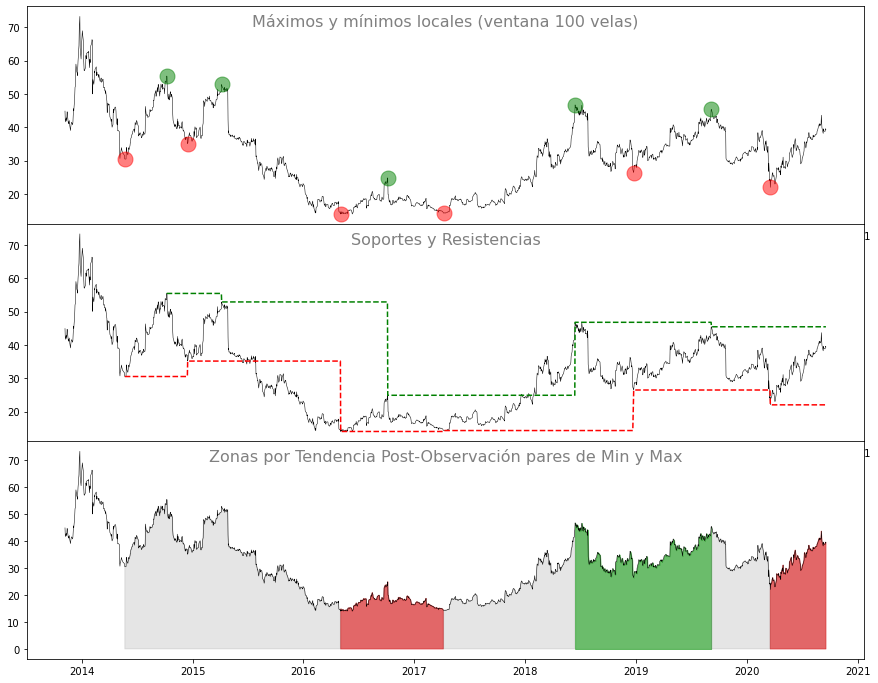

In [22]:
trends('TWTR', sensibilidad=100)

[*********************100%***********************]  1 of 1 downloaded


,vMin,vMax,fecha,valor
2000-08-23,NaN,12.3996,2000-08-23,12.3996
2001-03-19,8.5646,NaN,2001-03-19,8.5646
2001-05-21,NaN,9.8873,2001-05-21,9.8873
2001-09-27,5.3239,NaN,2001-09-27,5.3239
2002-01-07,NaN,7.5604,2002-01-07,7.5604
2002-06-14,3.2012,NaN,2002-06-14,3.2012
2005-02-18,NaN,33.2831,2005-02-18,33.2831
2005-04-15,25.5823,NaN,2005-04-15,25.5823
2005-09-28,NaN,38.0415,2005-09-28,38.0415
2006-06-13,21.6671,NaN,2006-06-13,21.6671


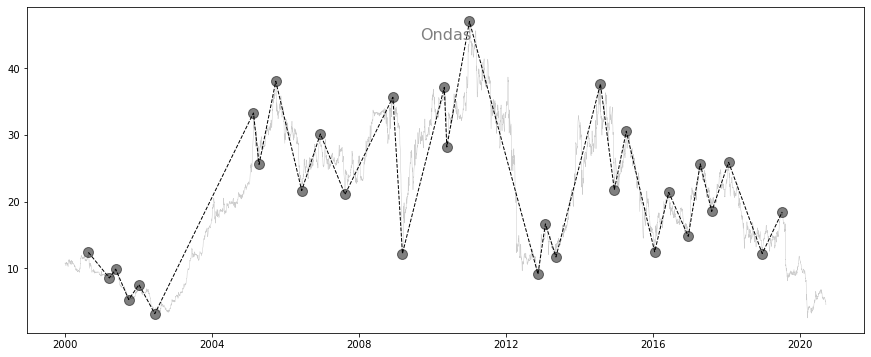

In [16]:
waves('YPF')

# API de la FED

El link general de acceso a la API es: 
 * https://www.transparency.treasury.gov/

Para acceder a sus datos vamos a importar las librerías de siempre:

In [1]:
import requests, pandas as pd

### Tipos de interés promedio:

Este endpoint nos trae datos de las tasas de interés de la reserva federal

Les dejo función de como llamar a la API básica:

In [28]:
import requests

def getRates(limit=100):
    base = 'https://www.transparency.treasury.gov/services/api/fiscal_service/v1/'
    url = base + 'accounting/od/avg_interest_rates'
    
    params = {'sort':'-reporting_date', 'limit':limit}
    
    r = requests.get(url, params=params)
    
    js = r.json()
    
    df = pd.DataFrame(js['data'])
    return df    
data = getRates(limit=1000)
data

,reporting_date,security_type_desc,security_desc,avg_interest_rate_amt,reporting_fiscal_year,reporting_fiscal_quarter,reporting_calendar_year,reporting_calendar_quarter,reporting_calendar_month,reporting_calendar_day,reporting_fiscal_month
0,2020-08-31,Interest-bearing Debt,Total Interest-bearing Debt,1.795,2020,4,2020,3,08,31,11
1,2020-08-31,Marketable,Federal Financing Bank,2.644,2020,4,2020,3,08,31,11
2,2020-08-31,Marketable,Total Marketable,1.661,2020,4,2020,3,08,31,11
3,2020-08-31,Marketable,Treasury Bills,0.207,2020,4,2020,3,08,31,11
4,2020-08-31,Marketable,Treasury Bonds,3.529,2020,4,2020,3,08,31,11
...,...,...,...,...,...,...,...,...,...,...,...
995,2015-08-31,Non-marketable,Hope Bonds,0.010,2015,4,2015,3,08,31,11
996,2015-08-31,Non-marketable,State and Local Government Series,1.224,2015,4,2015,3,08,31,11
997,2015-08-31,Non-marketable,Total Non-marketable,3.113,2015,4,2015,3,08,31,11
998,2015-08-31,Non-marketable,United States Savings Inflation Securities,1.392,2015,4,2015,3,08,31,11


Como pueden ver, acepta como parámetro el orden y la cantidad "limit" de datos a devolver

Con la siguiente consulta vamos a traer los ultimos valores:

In [3]:
data = getRates()
ultimos = data.groupby('security_desc').avg_interest_rate_amt.first()
ultimos

security_desc
Domestic Series                                   8.044
Federal Financing Bank                            2.644
Foreign Series                                    7.312
Government Account Series                         2.261
Government Account Series Inflation Securities    1.257
Special Purpose Vehicle                           0.070
State and Local Government Series                 1.290
Total Interest-bearing Debt                       1.795
Total Marketable                                  1.661
Total Non-marketable                              2.231
Treasury Bills                                    0.207
Treasury Bonds                                    3.529
Treasury Floating Rate Note (FRN)                 0.261
Treasury Inflation-Protected Securities (TIPS)    0.693
Treasury Notes                                    1.898
United States Savings Inflation Securities        3.163
United States Savings Securities                  2.875
Name: avg_interest_rate_amt, dtype

In [29]:
df = getRates(limit=5000).set_index('reporting_date')

In [30]:
df = df.loc[df['security_desc'] == 'Treasury Bills', ['avg_interest_rate_amt']]

In [31]:
df = df.astype('float')
df.index = pd.to_datetime(df.index)

<AxesSubplot:xlabel='reporting_date'>

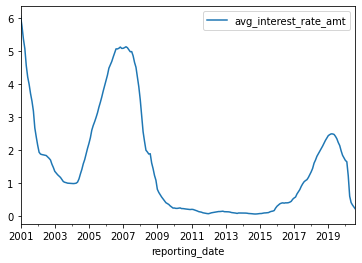

In [32]:
df.plot()

In [ ]:
from tokens import *

In [82]:
import requests
import datetime

token = 'btdgl3n48v6rmon0ae4g'

def download(symbol, interval, from_o, to_o):
    
    intervalos = [1, 5, 15, 30, 60, 'D', 'W', 'M']
    if interval in intervalos:
        from_ts = int(from_o.timestamp())
        to_ts = int(to_o.timestamp())

        url = 'https://finnhub.io/api/v1/stock/candle'
        params = {'symbol':symbol,'resolution':interval,'from':from_ts,'to':to_ts,'token':token}

        r = requests.get(url=url, params=params)
        js = r.json()

        df = pd.DataFrame(js)
        df.set_index('t', inplace=True)
        df.index = pd.to_datetime(df.index, unit='s')

        errores = df.loc[df.s != 'ok']
        if len(errores) > 0:
            print('Ojo que hay gfechas con errores', errores)

        
        df = df.loc[ : , ['o','h','l','c','v']  ]
        #df.drop(['s'], axis=1, inplace=True)
        df.columns = ['Open','High','Low','Close','Volume']
        df.index.name = 'Date'
        

    else:
        print('El intervalo no es valido, los validos son ', intervalos)
        df = pd.DataFrame()
    
    
    return df

In [74]:
import datetime

In [75]:
hoy = datetime.datetime.now()
hoy.timestamp()

1600469080.906953

In [76]:
from_o = datetime.datetime(2020,5,1)
to_o = datetime.datetime(2020,8,31)

In [84]:
data = download('AAPL',interval = 'D',from_o = from_o, to_o = to_o)
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-04,72.292503,73.422501,71.579300,73.290001,133568000
2020-05-05,73.764999,75.250000,73.614998,74.389999,147751008
2020-05-06,75.114998,75.809998,74.717499,75.157501,142334000
2020-05-07,75.805000,76.292503,75.492500,75.934998,115215000
2020-05-08,76.410004,77.587502,76.072502,77.532501,134048000
...,...,...,...,...,...
2020-08-25,124.697502,125.179298,123.052498,124.824997,211496000
2020-08-26,126.179123,126.992500,125.082497,126.522499,163022000
2020-08-27,127.142502,127.485001,123.832497,125.010002,155552000


In [81]:
data.round(2)

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-04,72.29,73.42,71.58,73.29,133568000
2020-05-05,73.76,75.25,73.61,74.39,147751008
2020-05-06,75.11,75.81,74.72,75.16,142334000
2020-05-07,75.81,76.29,75.49,75.93,115215000
2020-05-08,76.41,77.59,76.07,77.53,134048000
...,...,...,...,...,...
2020-08-25,124.70,125.18,123.05,124.82,211496000
2020-08-26,126.18,126.99,125.08,126.52,163022000
2020-08-27,127.14,127.49,123.83,125.01,155552000


# Binance

In [87]:
def historico(symbol, interval='1d', startTime=None, endTime=None, limit=1000):
    
    url = 'https://api.binance.com/api/v3/klines'
    
    params = {'symbol':symbol, 'interval':interval, 
              'startTime':startTime, 'endTime':endTime, 'limit':limit}
        
    r = requests.get(url, params=params)
    js = r.json()
    
    # Armo el dataframe
    cols = ['openTime','Open','High','Low','Close','Volume','cTime',
            'qVolume','trades','takerBase','takerQuote','Ignore']
    
    df = pd.DataFrame(js, columns=cols)
    
    #Convierto los valores strings a numeros
    df = df.apply(pd.to_numeric)
    
    # Le mando indice de timestamp
    df.index = pd.to_datetime(df.openTime, unit='ms')
    
    # Elimino columnas que no quiero
    df =df.drop(['openTime','cTime','takerBase','takerQuote','Ignore'],axis=1)
    df['vol_mln'] = df['qVolume'] / 10**6
    return df

historico('BTCUSDT', interval='2h', limit=10000)

,Open,High,Low,Close,Volume,qVolume,trades,vol_mln
openTime,,,,,,,,
2020-06-27 14:00:00,9157.50,9168.48,9113.00,9130.76,2793.500073,2.554892e+07,35795,25.548920
2020-06-27 16:00:00,9130.82,9149.49,9055.00,9080.29,6511.565164,5.922898e+07,60383,59.228982
2020-06-27 18:00:00,9080.30,9108.00,8833.00,8938.04,9991.464231,8.967813e+07,90494,89.678129
2020-06-27 20:00:00,8937.45,9099.00,8900.22,9062.99,7499.103380,6.728477e+07,76060,67.284766
2020-06-27 22:00:00,9060.83,9078.07,8940.15,9012.00,4307.252635,3.881346e+07,46832,38.813459
...,...,...,...,...,...,...,...,...
2020-09-18 14:00:00,10914.51,10954.11,10870.37,10899.37,4834.100631,5.277648e+07,75979,52.776484
2020-09-18 16:00:00,10899.42,10900.00,10812.84,10834.42,6643.705586,7.213532e+07,92179,72.135323
2020-09-18 18:00:00,10834.43,10880.00,10818.00,10866.55,4326.533372,4.695933e+07,69533,46.959332
